In [1]:
!pip install torch torchvision
!pip install medicaltorch

In [2]:
import torch
import torchvision
import medicaltorch
print(torch.__version__)
print(torchvision.__version__)
print(medicaltorch.__version__)

2.4.1+cu121
0.19.1+cu121
0.2


In [3]:
!find / -name datasets.py

/root/.cache/uv/archive-v0/GRgO7dXe5f9WYYdMjOmq2/dask_expr/datasets.py
/root/.cache/uv/archive-v0/_Bl3hvf6SKReofnaJfWO5/shap/datasets.py
/root/.cache/uv/archive-v0/QKIe-6AnJqh9fxQkUuzHd/dask/datasets.py
/root/.cache/uv/archive-v0/pA5OY0zS50qQj3EAoT84p/catboost/datasets.py
/root/.cache/uv/archive-v0/EHTGtr8lIqSKarNkC80M9/kagglehub/datasets.py
/usr/local/lib/python3.10/dist-packages/medicaltorch/datasets.py
/usr/local/lib/python3.10/dist-packages/shap/datasets.py
/usr/local/lib/python3.10/dist-packages/dask/datasets.py
/usr/local/lib/python3.10/dist-packages/kagglehub/datasets.py
/usr/local/lib/python3.10/dist-packages/dask_expr/datasets.py
/usr/local/lib/python3.10/dist-packages/catboost/datasets.py
/usr/local/lib/python3.10/dist-packages/tensorflow/python/tpu/datasets.py
/usr/local/lib/python3.10/dist-packages/geemap/datasets.py
/usr/local/lib/python3.10/dist-packages/arviz/data/datasets.py
/usr/local/lib/python3.10/dist-packages/cudf/datasets.py


In [4]:
!find /usr/local/lib/python3.10/dist-packages/ -name datasets.py


/usr/local/lib/python3.10/dist-packages/medicaltorch/datasets.py
/usr/local/lib/python3.10/dist-packages/shap/datasets.py
/usr/local/lib/python3.10/dist-packages/dask/datasets.py
/usr/local/lib/python3.10/dist-packages/kagglehub/datasets.py
/usr/local/lib/python3.10/dist-packages/dask_expr/datasets.py
/usr/local/lib/python3.10/dist-packages/catboost/datasets.py
/usr/local/lib/python3.10/dist-packages/tensorflow/python/tpu/datasets.py
/usr/local/lib/python3.10/dist-packages/geemap/datasets.py
/usr/local/lib/python3.10/dist-packages/arviz/data/datasets.py
/usr/local/lib/python3.10/dist-packages/cudf/datasets.py


In [5]:
file_path = "/usr/local/lib/python3.10/dist-packages/medicaltorch/datasets.py"

# Read the file and modify its content
with open(file_path, "r") as file:
    lines = file.readlines()

# Replace the deprecated import
new_lines = []
for line in lines:
    if "from torch._six import string_classes, int_classes" in line:
        new_lines.append("from collections.abc import Iterable\n")
        new_lines.append("string_classes = (str, bytes)\n")
        new_lines.append("int_classes = (int,)\n")
    else:
        new_lines.append(line)

# Write the updated content back
with open(file_path, "w") as file:
    file.writelines(new_lines)

print("File successfully updated!")


File successfully updated!


In [46]:
from collections import defaultdict
from collections.abc import Mapping
import time
import os

import numpy as np
from tqdm import tqdm

from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch 
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import matplotlib.pyplot as plt

cudnn.benchmark = True

In [47]:
ROOT_DIR_GMCHALLENGE = "/kaggle/input/cadiac/Task02_Heart"
mri_input_filename = os.path.join(ROOT_DIR_GMCHALLENGE, '/kaggle/input/cadiac/Task02_Heart/imagesTr/la_005.nii')

mri_gt_filename = os.path.join(ROOT_DIR_GMCHALLENGE, '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_005.nii')


In [48]:
pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)

(320, 320)
(320, 320)


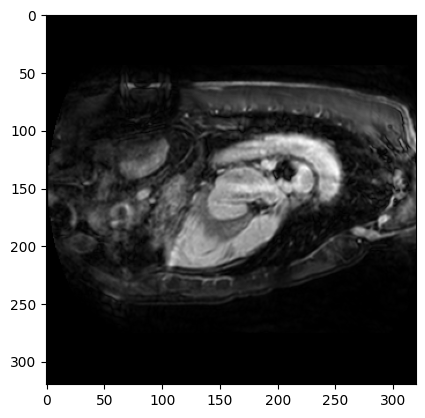

In [49]:
slice_pair = pair.get_pair_slice(55)   ## Slice Number

input_slice = slice_pair["input"]
print(input_slice.shape)
gt_slice = slice_pair["gt"]
print(gt_slice.shape)

img = input_slice
plt.imshow(img,cmap='gray')
plt.show()

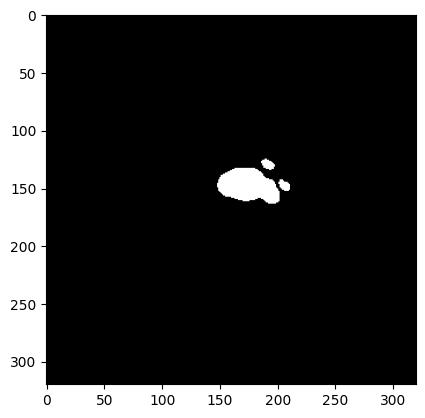

In [50]:
img = gt_slice
plt.imshow(img,cmap='gray')
plt.show()

In [51]:
img_data, seg_data = pair.get_pair_data()
print(img_data.shape)
print(seg_data.shape)

(320, 320, 120)
(320, 320, 120)


In [52]:
img_list = os.listdir(os.path.join(ROOT_DIR_GMCHALLENGE,'imagesTr'))
label_list = os.listdir(os.path.join(ROOT_DIR_GMCHALLENGE,'labelsTr'))

In [53]:
filename_pairs = [(os.path.join(ROOT_DIR_GMCHALLENGE,'imagesTr',x),os.path.join(ROOT_DIR_GMCHALLENGE,'labelsTr',y)) for x,y in zip(img_list,label_list)]

In [54]:
print(len(filename_pairs))

21


In [55]:
filename_pairs

[('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_017.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_017.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_010.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_010.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_003.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_003.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/._la_029.nii.gz',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/._la_029.nii.gz'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_021.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_021.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_016.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_016.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_024.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_024.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_004.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_004.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/i

In [56]:
filename_pairs_train = [
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_003.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_003.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_004.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_004.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_005.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_005.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_007.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_007.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_009.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_009.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_010.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_010.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_011.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_011.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_014.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_014.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_016.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_016.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_017.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_017.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_018.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_018.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_019.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_019.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_020.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_020.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_021.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_021.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_022.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_022.nii')
                 
]

In [57]:
len(filename_pairs_train)

15

In [58]:
filename_pairs_train

[('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_003.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_003.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_004.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_004.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_005.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_005.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_007.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_007.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_009.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_009.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_010.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_010.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_011.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_011.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_014.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_014.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la

In [59]:
filename_pairs_val = [
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_023.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_023.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_024.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_024.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_026.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_026.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_029.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_029.nii'),
                  ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_030.nii','/kaggle/input/cadiac/Task02_Heart/labelsTr/la_030.nii')
                  
]

In [60]:
len(filename_pairs_val)

5

In [61]:
filename_pairs_val

[('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_023.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_023.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_024.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_024.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_026.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_026.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_029.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_029.nii'),
 ('/kaggle/input/cadiac/Task02_Heart/imagesTr/la_030.nii',
  '/kaggle/input/cadiac/Task02_Heart/labelsTr/la_030.nii')]

In [62]:
pip install --upgrade medicaltorch


Note: you may need to restart the kernel to use updated packages.


In [63]:
train_transform = transforms.Compose([
    # mt_transforms.Resample(0.25, 0.25),
    # mt_transforms.CenterCrop2D((256,256)),
    # mt_transforms.ElasticTransform(alpha_range = (28.0, 30.0),
    #                               sigma_range = (3.5, 4.0),
    #                               p = 0.3),
    # mt_transforms.RandomAffine(degrees = 4.6,
    #                           scale = (0.98, 1.02),
    #                           translate = (0.03, 0.03)),

    mt_transforms.ToTensor(),
    mt_transforms.NormalizeInstance(),
])

val_transform = transforms.Compose([
        # mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((256, 256)),

        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])


from torchvision import transforms
import medicaltorch.transforms as mt_transforms

# train_transform = transforms.Compose([
#     # Remove Resample if not required, as it was commented out in your code
#     mt_transforms.CenterCrop2D((256, 256)),  # Cropping the center of the image to (256, 256)
    
#     # Elastic Transform (Check if 'alpha_range' and 'sigma_range' are still valid params)
#     mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
#                                    sigma_range=(3.5, 4.0),
#                                    p=0.3),  # 'p' controls the probability

#     # RandomAffine update to remove 'resample', added 'shear' to preserve affine flexibility
#     mt_transforms.RandomAffine(degrees=4.6,
#                                scale=(0.98, 1.02),
#                                translate=(0.03, 0.03),
#                                shear=0),  # No shear, just the scaling, rotation, and translation

#     # Convert to Tensor and normalize with instance-wise statistics
#     mt_transforms.ToTensor(),
#     mt_transforms.NormalizeInstance(),  # Instance normalization instead of global normalization
# ])

# val_transform = transforms.Compose([
#     # Resample commented out as it was not used
#     mt_transforms.CenterCrop2D((256, 256)),  # Center crop for validation set
    
#     # Convert to Tensor and normalize with instance-wise statistics
#     mt_transforms.ToTensor(),
#     mt_transforms.NormalizeInstance(),
# ])


In [64]:
train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs_train,transform=train_transform)
val_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs_val,transform=val_transform)


In [65]:
len(train_dataset)

1702

In [66]:
len(val_dataset)

569

In [67]:
train_dataloader = DataLoader(train_dataset, batch_size =16,
                             shuffle = True, num_workers = 1,
                             collate_fn = mt_datasets.mt_collate)

val_dataloader = DataLoader(val_dataset, batch_size = 16,
                           shuffle = True, num_workers =1,
                           collate_fn = mt_datasets.mt_collate)

In [69]:
batch = next(iter(train_dataloader))
print(batch)  # Check the structure of the batch


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/medicaltorch/datasets.py", line 494, in mt_collate
    elif isinstance(batch[0], collections.Mapping):
AttributeError: module 'collections' has no attribute 'Mapping'


In [68]:
batch = next(iter(train_dataloader))

for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/medicaltorch/datasets.py", line 494, in mt_collate
    elif isinstance(batch[0], collections.Mapping):
AttributeError: module 'collections' has no attribute 'Mapping'
